Import Modules


In [1]:
#  import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import datetime as dt
# prophet model
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error

C:\Users\zscho\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the Dataset

In [2]:
# load and print the dataset
df = pd.read_csv('TWITTER.csv')
df.head()

Date       Open       High        Low      Close  Adj Close  \
0  2013-11-07  45.099998  50.090000  44.000000  44.900002  44.900002   
1  2013-11-08  45.930000  46.939999  40.689999  41.650002  41.650002   
2  2013-11-11  40.500000  43.000000  39.400002  42.900002  42.900002   
3  2013-11-12  43.660000  43.779999  41.830002  41.900002  41.900002   
4  2013-11-13  41.029999  42.869999  40.759998  42.599998  42.599998   

      Volume  
0  117701600  
1   27925300  
2   16113900  
3    6316700  
4    8688300

In [3]:
# perform a basic statistical analysis
df.describe()

Open         High          Low        Close    Adj Close  \
count  2172.000000  2172.000000  2172.000000  2172.000000  2172.000000   
mean     35.759811    36.435994    35.069503    35.732063    35.732063   
std      14.305437    14.562577    14.003070    14.269980    14.269980   
min      13.950000    14.220000    13.730000    14.010000    14.010000   
25%      24.822500    25.549999    24.129999    24.862501    24.862501   
50%      34.900002    35.430000    34.295000    34.754999    34.754999   
75%      44.209999    45.095000    43.230000    44.132500    44.132500   
max      78.360001    80.750000    76.050003    77.629997    77.629997   

             Volume  
count  2.172000e+03  
mean   2.191115e+07  
std    1.907344e+07  
min    3.661100e+06  
25%    1.258305e+07  
50%    1.713035e+07  
75%    2.430645e+07  
max    2.684654e+08

In [4]:
# print a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2172 non-null   object 
 1   Open       2172 non-null   float64
 2   High       2172 non-null   float64
 3   Low        2172 non-null   float64
 4   Close      2172 non-null   float64
 5   Adj Close  2172 non-null   float64
 6   Volume     2172 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 118.9+ KB


In [5]:
# change the Date column type to datetime
df["Date"] = pd.to_datetime(df['Date'])

# Plot the Dataset

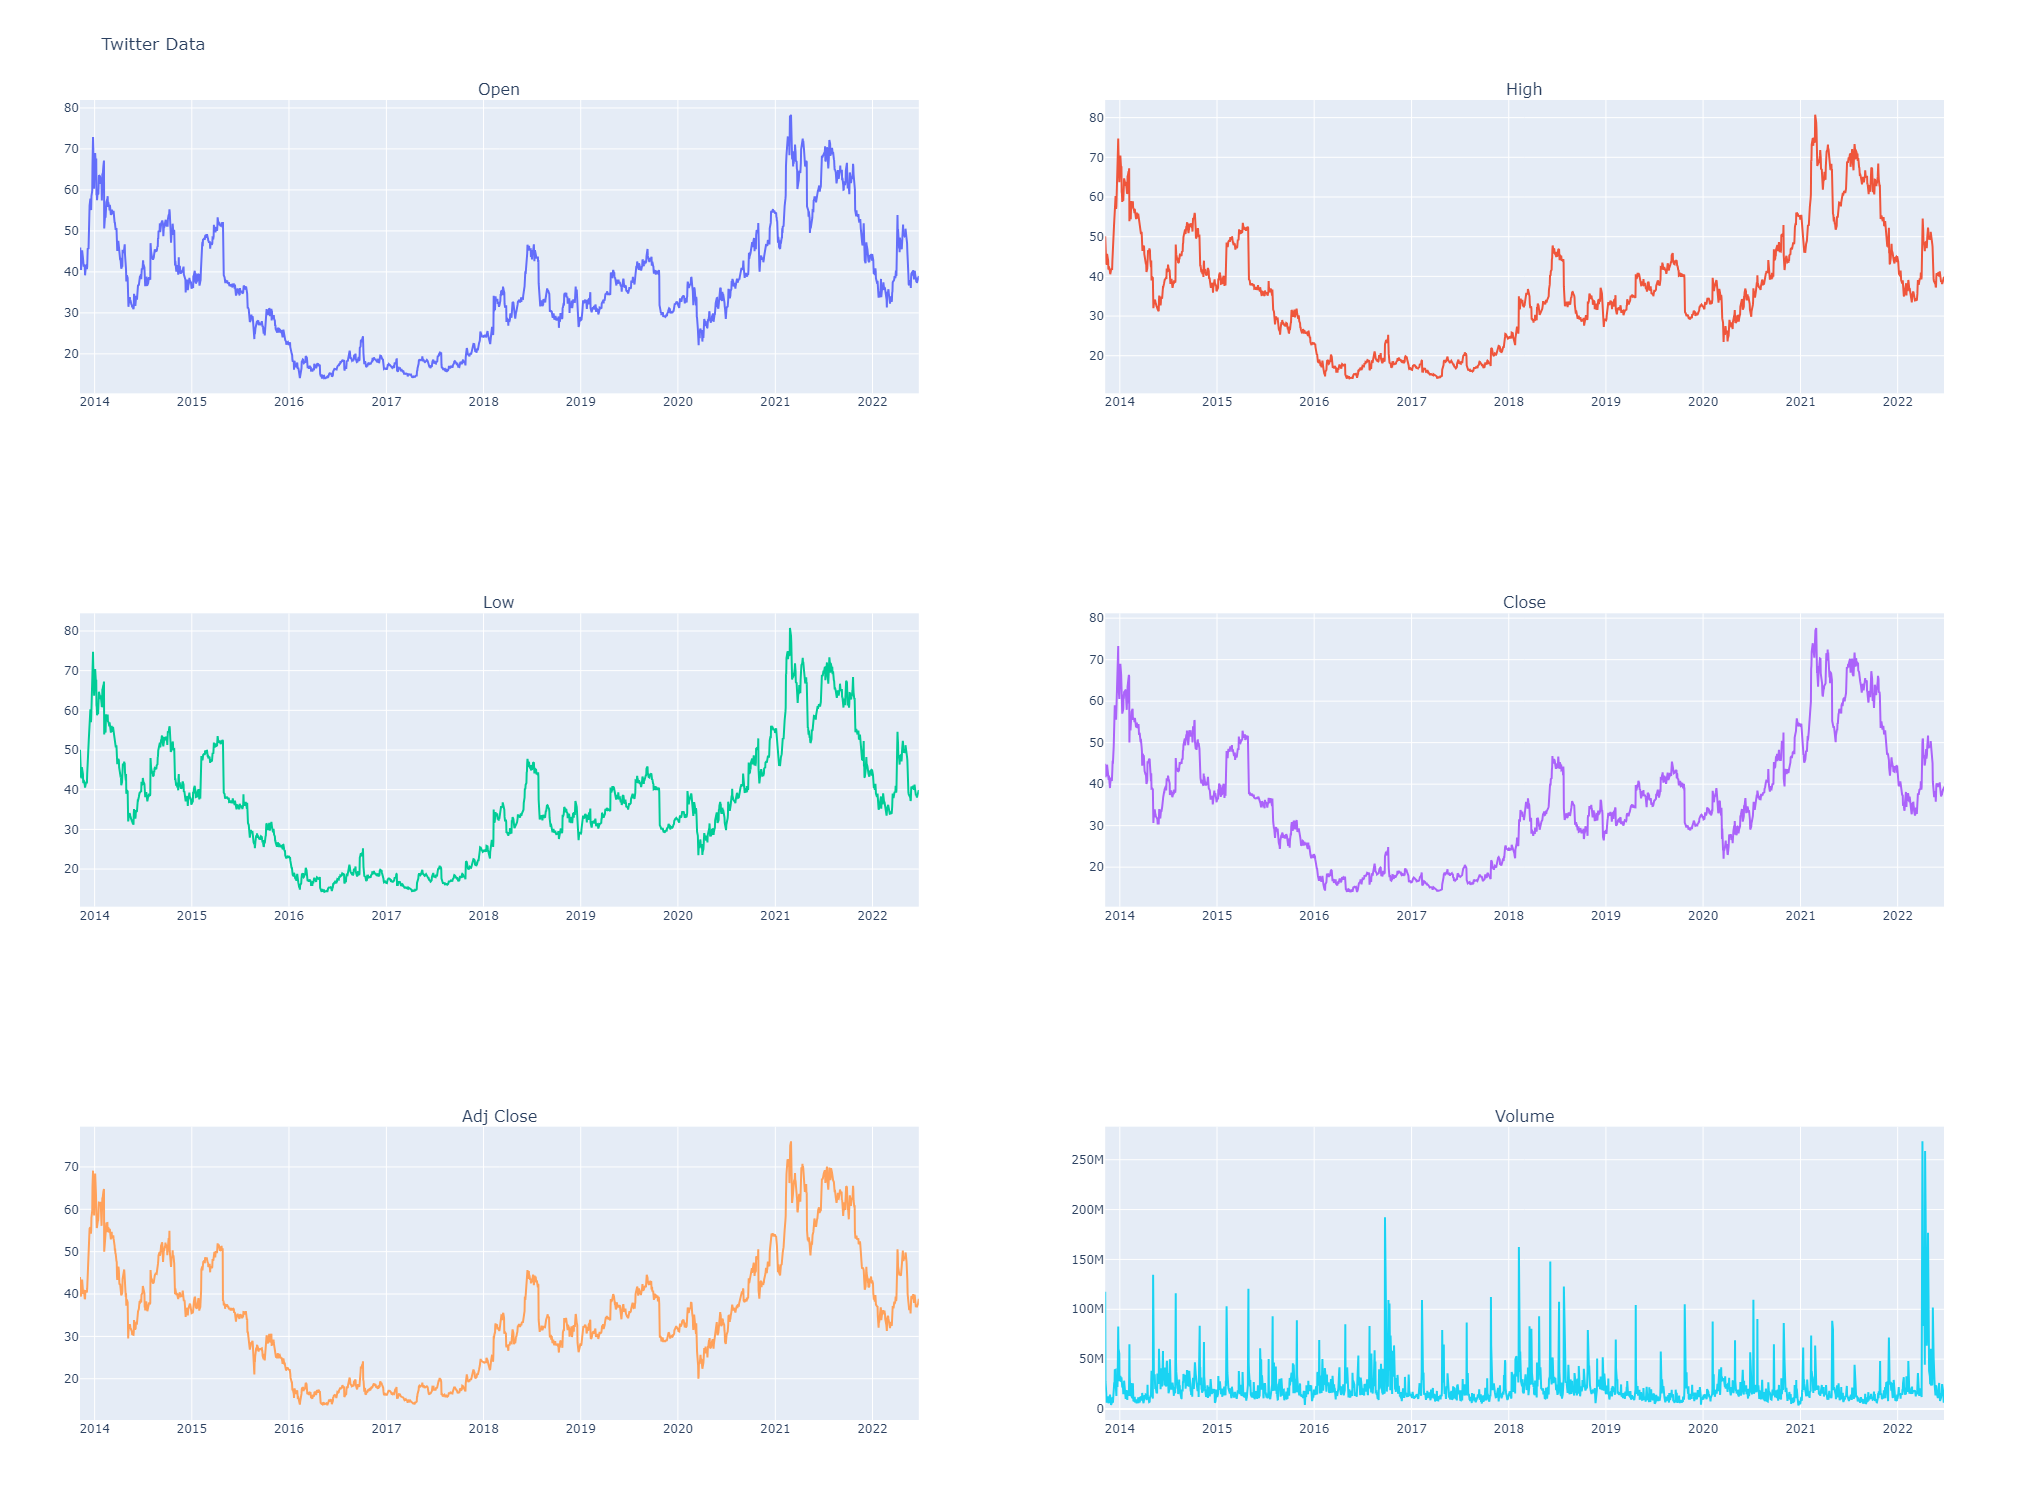

In [6]:
# create the subplots
columns = df.columns[1:]
fig = make_subplots(rows=3, cols=2, subplot_titles=columns)
for row in range(1, 4):
    for col in range(1, 3):
        column = columns[row * col - 1]
        fig.add_trace(go.Scatter(x = df['Date'] ,y = df[column]),row=row, col=col)
fig.update_layout(height=1500, width=1000, title_text="Twitter Data", showlegend=False)
fig.show()

# Comparison of Volumes for Each Year


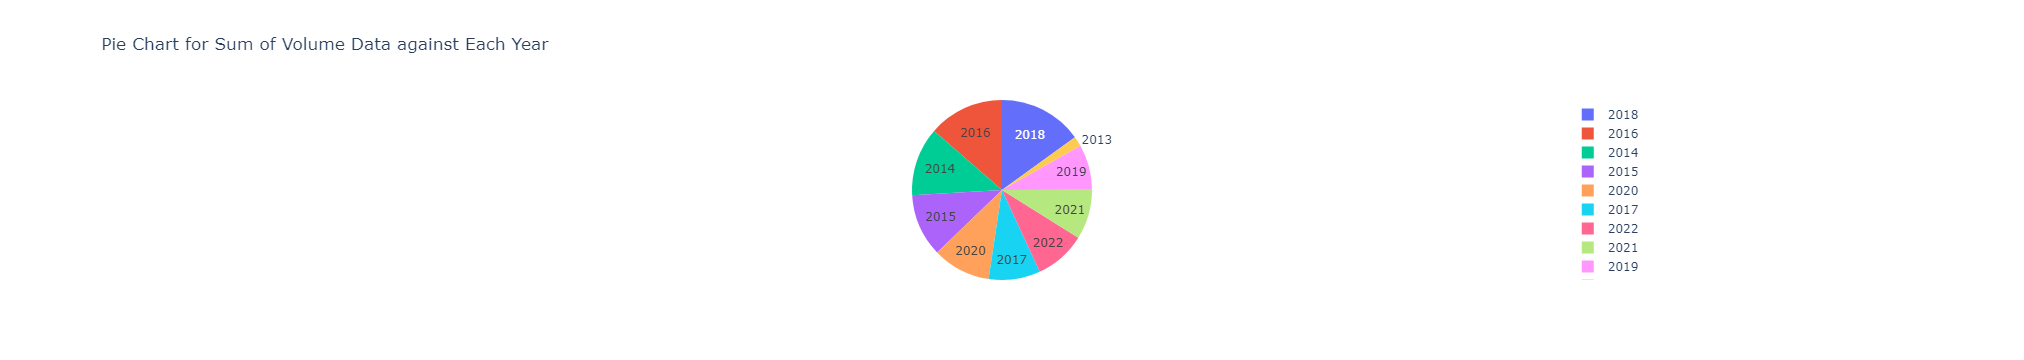

In [7]:
# create the pie chart
df['Year'] = df['Date'].dt.year
df_pie = df.groupby('Year')['Volume'].sum()

layout = {
    'title': 'Pie Chart for Sum of Volume Data against Each Year'}

fig = go.Figure(data=[go.Pie(labels=df_pie.index, values=df_pie.values, textinfo='label')], layout=layout)
fig.show()

# Create an OHLC Chart

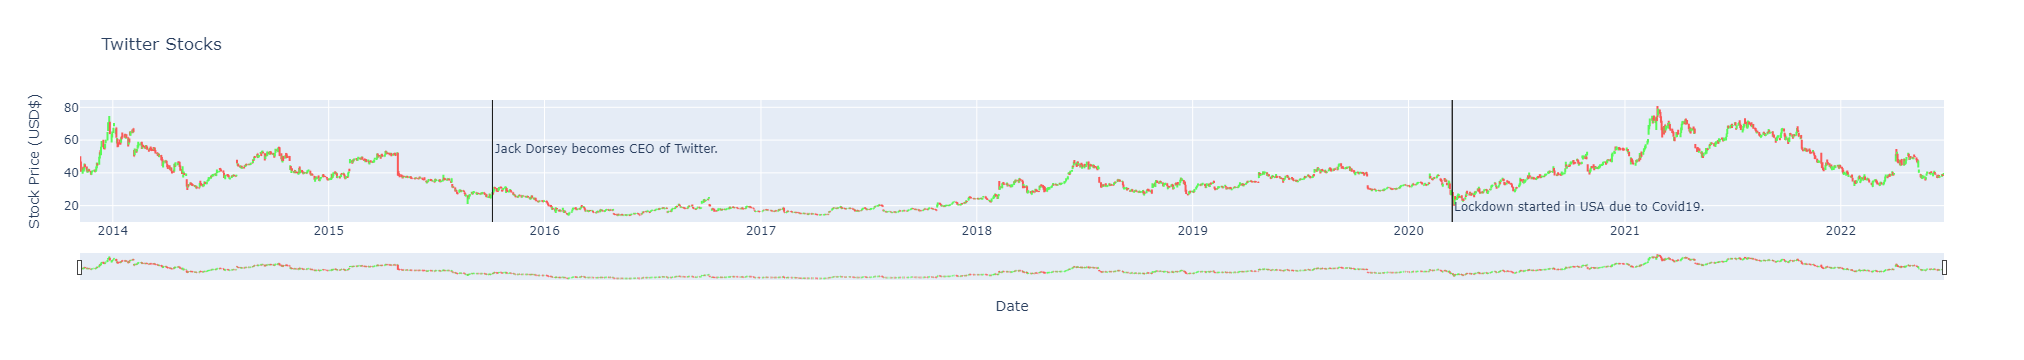

In [8]:
# create the OHLC chart
data = go.Ohlc(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
               increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))

layout = {
    'title': 'Twitter Stocks',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2015-10-05', 'x1': '2015-10-05',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
        },
        {
        'x0': '2020-03-15', 'x1': '2020-03-15',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }
    ],
    'annotations': [{
        'x': '2015-10-05', 'y': 0.6, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': 'Jack Dorsey becomes CEO of Twitter.'
        },
        {
        'x': '2020-03-15', 'y': 0.05, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': 'Lockdown started in USA due to Covid19.'
    }
    ]
}

fig = go.Figure(data=[data], layout=layout)
fig.update(layout_xaxis_rangeslider_visible=True)
fig.show()

# Take a Closer Look at OHLC Chart


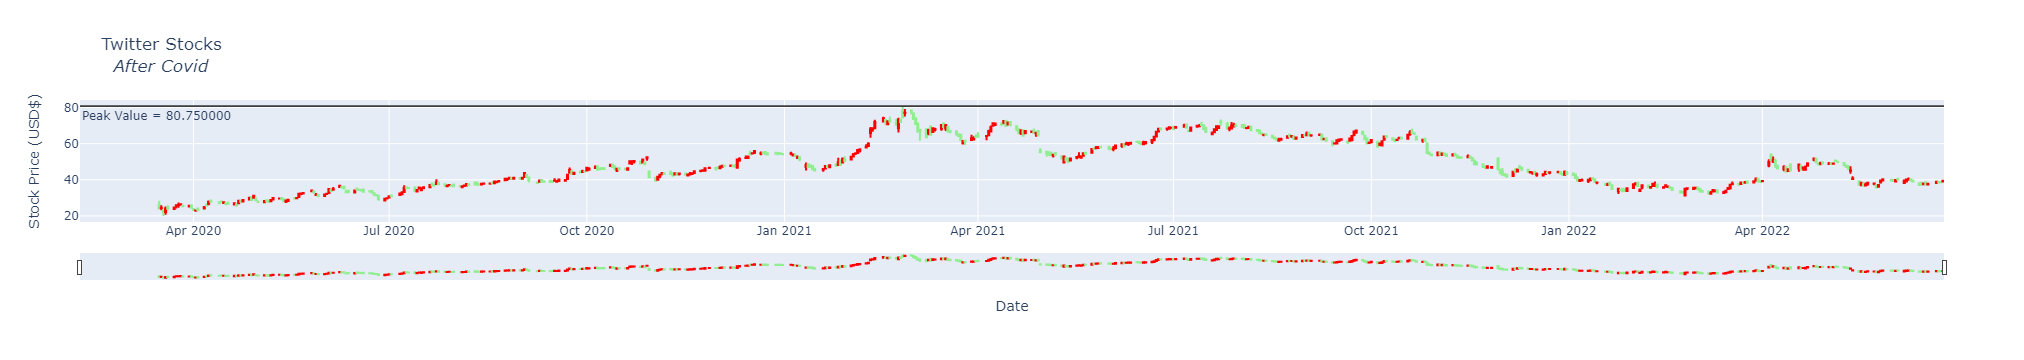

In [9]:
# create the candlestick chart
after_covid = df.loc[df['Date'] > '2020-03-15']
max_value = after_covid.iloc[:,1:-2].max().max()

g = after_covid.groupby(["Date"])
monthly_averages = g.aggregate({"Open": np.mean, "High": np.mean, "Low": np.mean, "Close":np.mean})
monthly_averages.reset_index(level=0, inplace=True)

trace = go.Candlestick(x=monthly_averages['Date'],
                       open=monthly_averages['Open'].values.tolist(),
                       high=monthly_averages['High'].values.tolist(),
                       low=monthly_averages['Low'].values.tolist(),
                       close=monthly_averages['Close'].values.tolist(),
                      increasing=dict(line=dict(color= 'red')),
                decreasing=dict(line=dict(color= 'lightgreen')))

layout = {
    'title': 'Twitter Stocks <br> <i> After Covid </i>',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': 0, 'x1': 1,
        'y0': max_value, 'y1': max_value, 'xref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
        }],
    'annotations': [{
        'x': '2020-03-15', 'y': 0.95, 'xref': 'x', 'yref': 'paper',
        'showarrow': False,
        'text': 'Peak Value = %f' %max_value
    }]
}


data = [trace]

fig = go.Figure(data=data, layout=layout)
fig.update(layout_xaxis_rangeslider_visible=True)
fig.show()

# Visualizing Moving Average


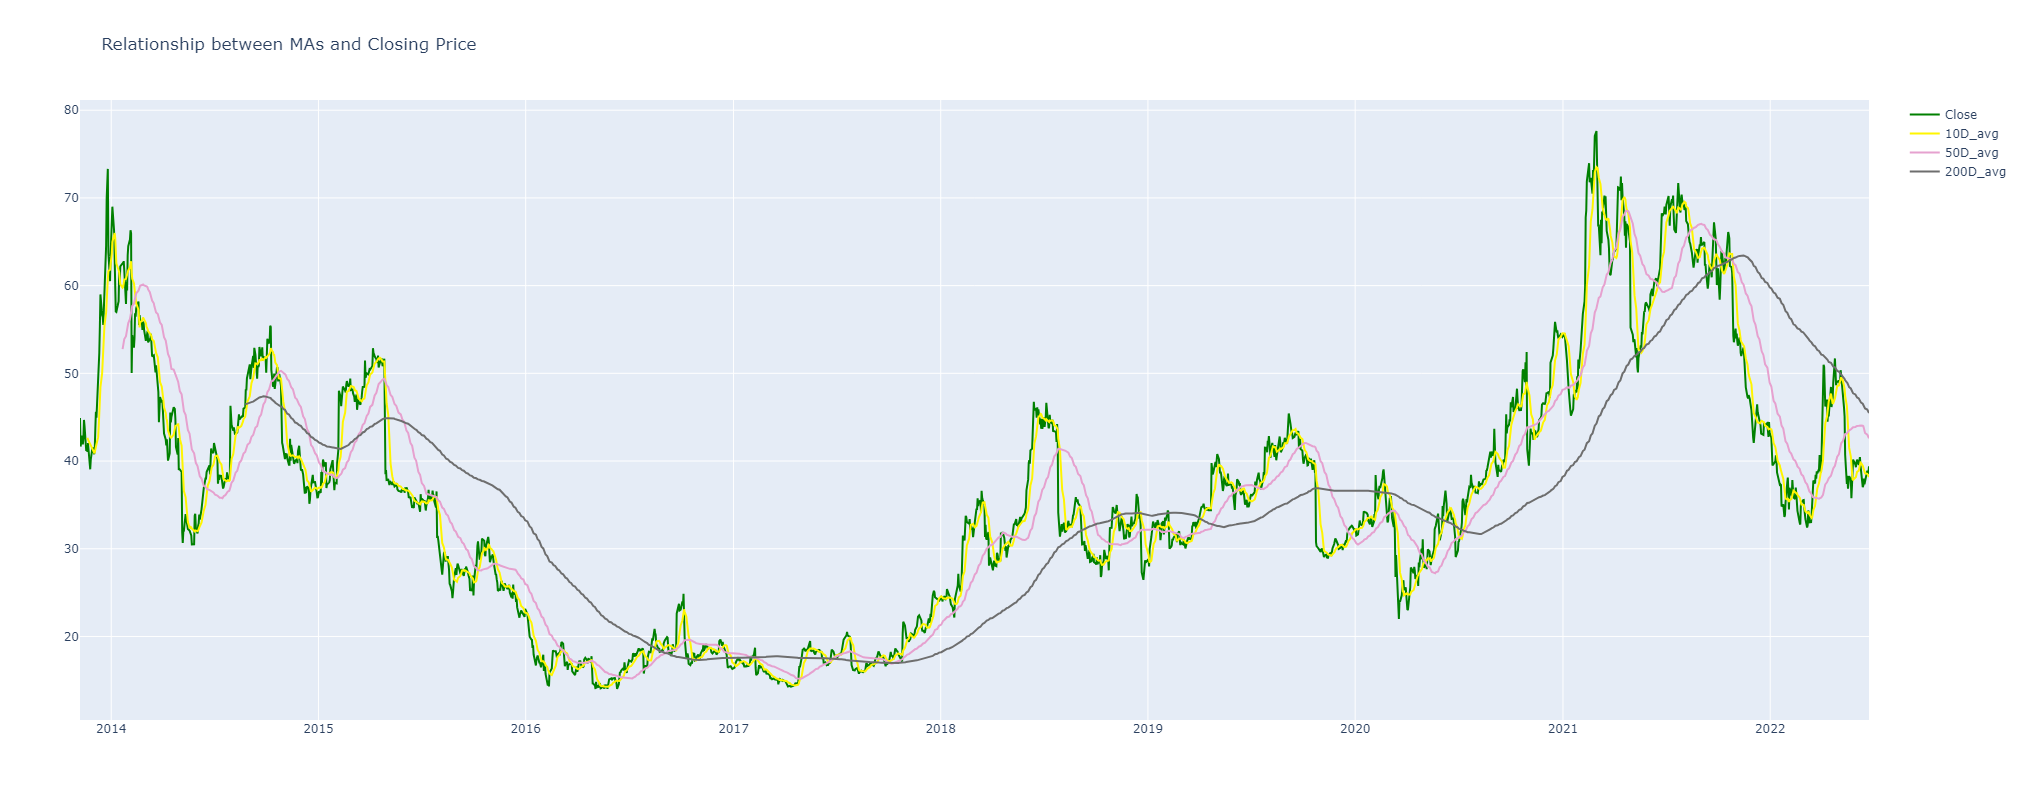

In [10]:
# plot the moving average along with the close price
# Moving Averages (10, 50 and 200)
df['10D_avg'] = df.Close.rolling(window=10).mean()
df['50D_avg'] = df.Close.rolling(window=50).mean()
df['200D_avg'] = df.Close.rolling(window=200).mean()

# Plot
fig = make_subplots()

colors = ['#ffF500', '#E6a1cf', '#6E6E6E']
avgs = ['10D_avg', '50D_avg', '200D_avg']

fig.append_trace({'x': df["Date"], 'y': df['Close'], 'type': 'scatter', 'name': 'Close', 'line': {'color': 'green'}}, 1, 1)

for col, c in zip(avgs, colors):
    fig.append_trace({'x': df["Date"], 'y': df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}}, 1, 1)

fig['layout'].update(height=800, title='Relationship between MAs and Closing Price')
    
fig.show()

# Predict Future Stocks


In [11]:
# create a new dataframe for training
df2 = df[["Date", "Close"]]
df2.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
df2.head()

C:\Users\zscho\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ds          y
0 2013-11-07  44.900002
1 2013-11-08  41.650002
2 2013-11-11  42.900002
3 2013-11-12  41.900002
4 2013-11-13  42.599998

In [12]:
# train the dataset
m = Prophet()

m.fit(df2)  

18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# make the predictions
# Create Future dates
future_prices = m.make_future_dataframe(periods=365, freq='D')

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
2532 2023-06-20  51.322931   40.933678   61.871997
2533 2023-06-21  51.393669   40.432828   62.671933
2534 2023-06-22  51.591473   40.012679   62.145506
2535 2023-06-23  51.718737   40.807957   62.456842
2536 2023-06-24  46.719611   35.475345   57.812080

# Plot the Predicted Values


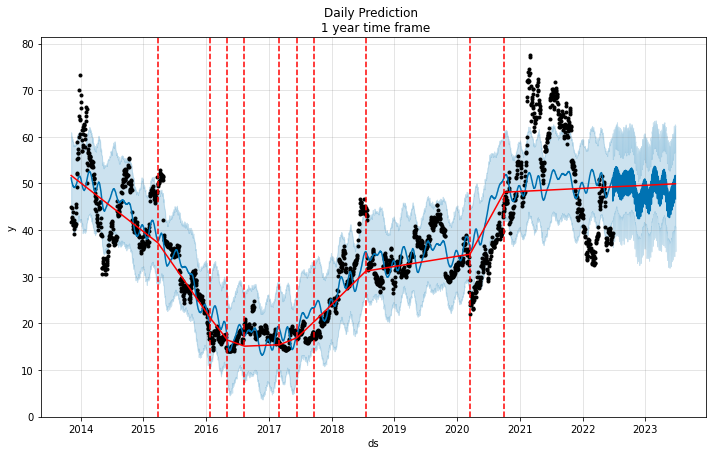

In [14]:
# plot the predicted data lines
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title("Daily Prediction \n 1 year time frame")
plt.show()

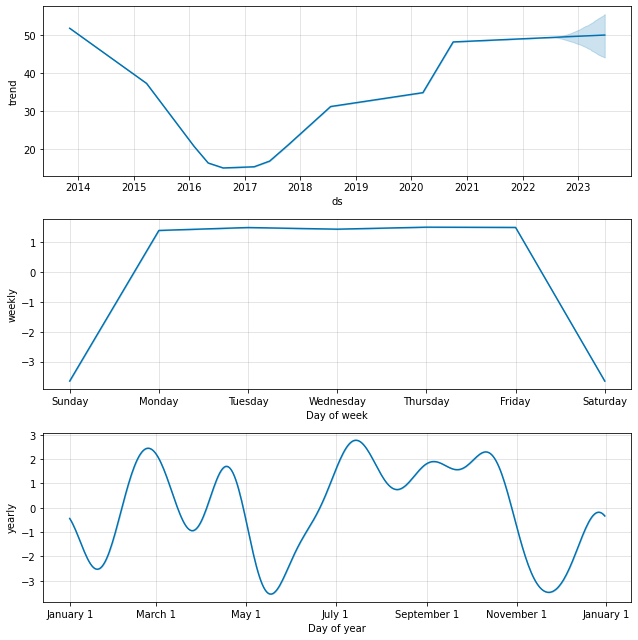

In [15]:
# create the subplots
fig = m.plot_components(forecast)
ax = fig.gca()
plt.show()

# Forecast Monthly Stock Data


In [16]:
# forecast the monthly predictions
m = Prophet(changepoint_prior_scale=0.03).fit(df2)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)


18:02:48 - cmdstanpy - INFO - Chain [1] start processing
18:02:48 - cmdstanpy - INFO - Chain [1] done processing


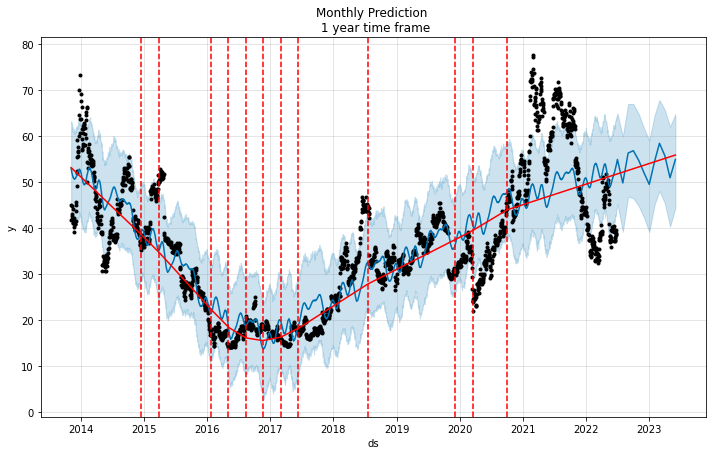

In [17]:
# plot the predicted data lines
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)
plt.title("Monthly Prediction \n 1 year time frame")
plt.show()

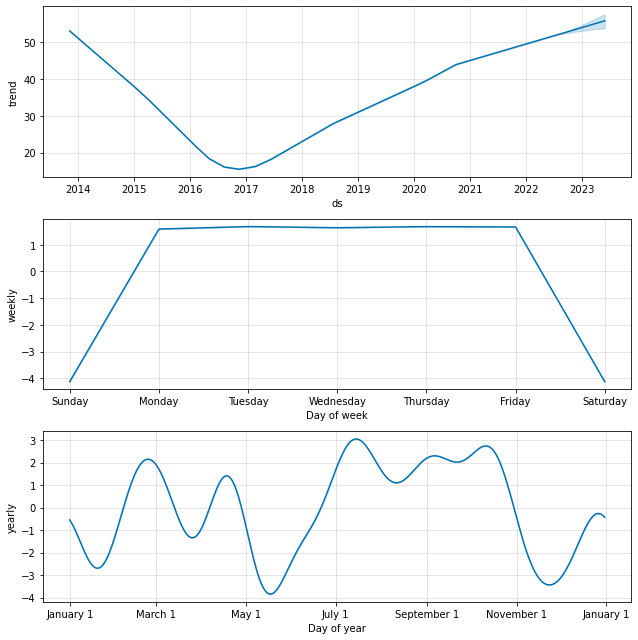

In [18]:
# create the subplots
fig = m.plot_components(fcst)
ax = fig.gca()
plt.show()

# Evaluate the Model

In [19]:
# evaluate the model and print the mean absolute error
y_true = df2['y'].values
y_pred = fcst['yhat'][:-12].values
mae = mean_absolute_error(y_true, y_pred)
mae

6.13640466454186

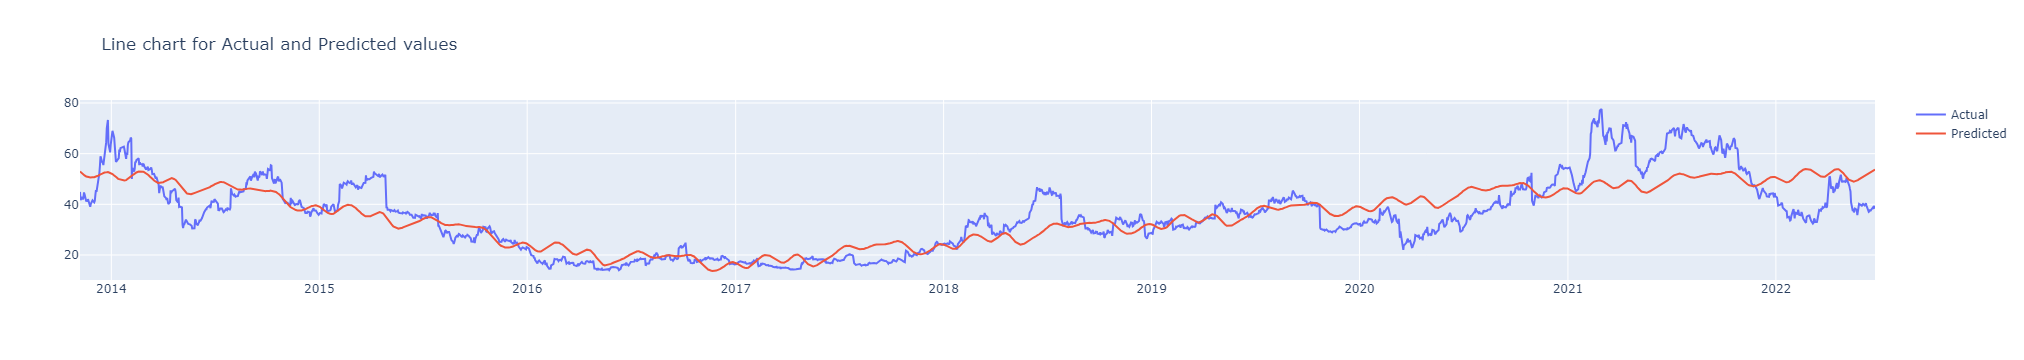

In [20]:
# create the graph for comparison
fig = go.Figure()
fig.add_trace(go.Scatter(x=df2['ds'], y=y_true,
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(x=df2['ds'], y=y_pred,
                    mode='lines',
                    name='Predicted'))
fig['layout'].update(title='Line chart for Actual and Predicted values')
fig.show()